# Implementing  BVEP brain network model in Stan


In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import re
import glob
from itertools import chain
from operator import itemgetter

import json
import pickle

import scikitplot as skplt
from sklearn.metrics import confusion_matrix

from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
from lib.parse_csv import parse_csv2
from lib.read_csvs import read_samples

from lib.report_nodetype import node_EzPzHz_idex
from lib.report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage
from lib.report_nodetype import node_score_std_extrm, node_score_ezpz

In [4]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [5]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [6]:
def f_int(x):
    return np.int(x)

f_vector_int = np.vectorize(f_int)

In [7]:
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Syntetic Data

In [8]:
data_dir = 'data_input_files'
results_dir = 'data_output_files'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

In [9]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /data/BVEP_SEEG_benchmark


In [10]:
Res_dir='Res_BVEP2_seeg_noncentered_reparam_euler_NUTS'

In [11]:
Mainpath =cwd+"/"

In [12]:
Reportmetrics_dir = os.path.join(cwd, Mainpath+"/data_output_files/figures/")

In [13]:
eta_true_inx, eta_true_mu, eta_true_sd = np.loadtxt(Mainpath+"ExperimentalData"+"/"+"eta_seeg_patient1"+".txt", delimiter=',', usecols=(0,1,2), skiprows=1, ).T 

In [14]:
with open(Mainpath+"ExperimentalData"+"/"+"true_labels_nodes_patient1"+".txt", 'r') as filehandle:  
          true_labels_nodes = json.load(filehandle)              

In [15]:
data_input = np.load(Mainpath+"data_input_files/"+"datainput_seeg_84nodes_patient1_euler.npz")

In [16]:
Obs_seeg = data_input['Obs_seeg']
x_source=data_input['x_source']
z_source=data_input['z_source']

SC = data_input['SC']
Gain = data_input['Gain']
ts = data_input['ts']
tau0 = data_input['tau0']
Ks = data_input['Ks']

ez_idx=data_input['ez_idx']
pz_idx=data_input['pz_idx']

ez_val=data_input['ez_val']
pz_val=data_input['pz_val']
hz_val=data_input['hz_val']

nn=data_input['nn']
ns=data_input['ns']
nt=data_input['nt']

In [17]:
nodes=np.r_[0:nn]

In [18]:
Obs_seeg.shape, x_source.shape

((130, 162), (130, 84))

In [19]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

In [20]:
eta_ez= float(ez_val)
eta_pz= float(pz_val)
eta_hz= float(hz_val)

In [21]:
eta_ez, eta_pz, eta_hz

(-1.6, -2.4, -3.5)

In [22]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [23]:
Ez_indices, Pz_indices, Hz_indices, Ez_arr, Pz_arr, Hz_arr= node_EzPzHz_idex(true_labels_nodes)

In [24]:
print("Ez_indices:", Ez_indices)
print("Pz_indices:", Pz_indices)

Ez_indices: [6, 34]
Pz_indices: [5, 11, 27]


## Observation

In [25]:
Obs_seeg.shape

(130, 162)

In [26]:
Seeg= Obs_seeg.T
Seeg.shape

(162, 130)

In [27]:
Seeg_area = np.trapz(Seeg, dx=0.0001)

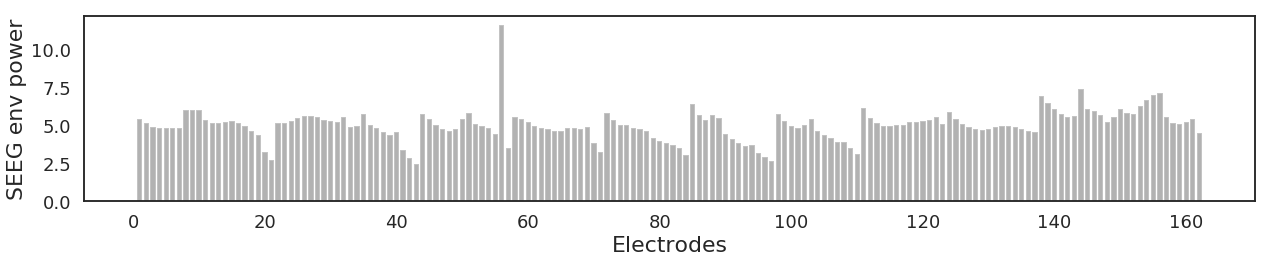

In [28]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_area.shape[0]+1), -Seeg_area, color='black', alpha=0.3);
plt.xlabel('Electrodes', fontsize=22)
plt.ylabel('SEEG env power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.eps"), dpi=800)
plt.show()

In [29]:
Seeg_pwr = np.sum((Seeg*Seeg), axis=1)
Seeg_pwr_n = (Seeg_pwr/ Seeg_pwr.max())

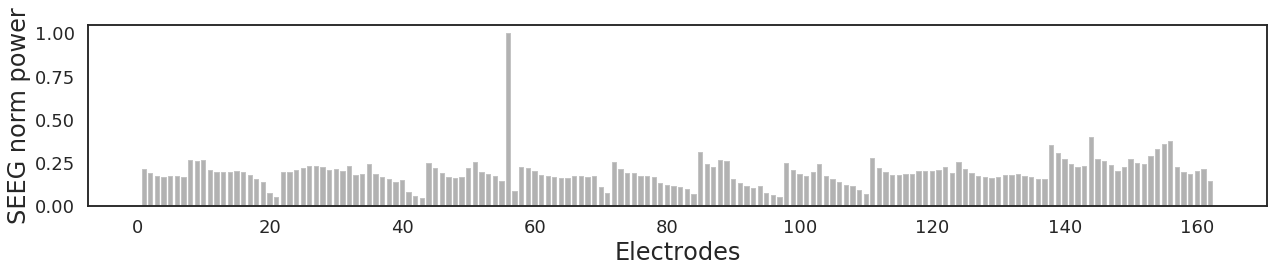

In [30]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1, Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='black', alpha=0.3);
plt.xlabel('Electrodes', fontsize=24)
plt.ylabel('SEEG norm power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.eps"), dpi=800)
plt.show()

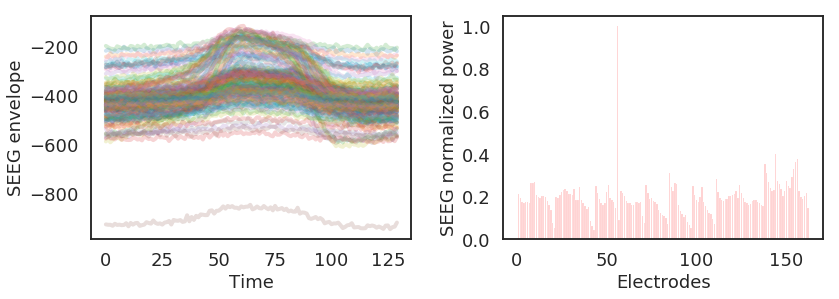

In [31]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.plot(Seeg.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=18)
plt.ylabel('SEEG envelope', fontsize=18)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='r', alpha=0.2)
plt.xlabel('Electrodes', fontsize=18)
plt.ylabel('SEEG normalized power', fontsize=18)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.eps"), dpi=800)
plt.show()

In [32]:
xs=x_source
zs=z_source

xs.shape, zs.shape

((130, 84), (130, 84))

In [33]:
xs_pwr = (xs*xs).sum (axis=0)
xs_pwr_n = (xs_pwr/ xs_pwr.max())

In [34]:
eni_idx=np.argsort(xs_pwr)
eni_idx

array([ 6, 34, 27, 11,  5, 83,  9, 29,  7, 23, 60, 14, 13, 20,  3, 28, 54,
       22, 39, 35,  8, 19,  4, 26,  0,  2, 58, 72, 76, 37, 33, 52, 63, 10,
       57, 36, 25, 68, 56, 15, 42, 38, 31, 12, 53, 40, 69, 32, 46, 75, 64,
       77, 21, 71, 43, 59, 44, 78, 16, 82, 62, 45, 61, 70, 18, 17, 41,  1,
       24, 55, 47, 74, 48, 80, 51, 30, 81, 66, 73, 79, 67, 50, 65, 49])

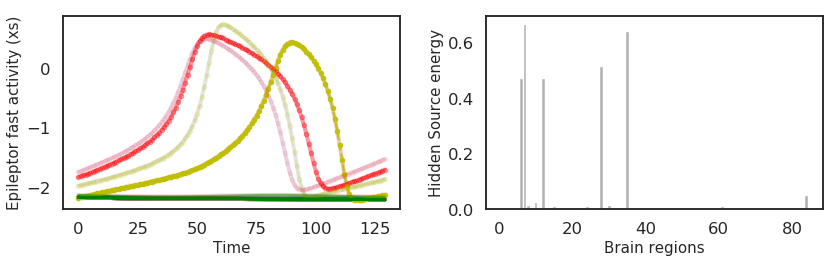

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, linewidth=4, alpha=0.2);
for i in range(xs.shape[1]):
    if i in Ez_indices:
        plot(xs[:,i], linestyle='-', marker='.', linewidth=4, color='r', alpha=2./i)
    elif i in Pz_indices:
        plot(xs[:,i], linestyle='--', marker='.',linewidth=2, color='y', alpha=4./i)
    else: 
        plot(xs[:,i], linestyle='-', linewidth=2, color='g', alpha=0.5)
#plt.title('Hidden source level activity')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Epileptor fast activity (xs)', fontsize=15)
plt.subplot(122)
plt.bar(np.arange(1,xs_pwr_n.shape[0]+1), 1.-xs_pwr_n, color='black', alpha=0.3)
#plt.title('Normalized power of hidden source level activity'
plt.xlabel('Brain regions', fontsize=15)
plt.ylabel('Hidden Source energy', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.eps"), dpi=800)
plt.show()

In [36]:
Seeg.shape, xs.shape

((162, 130), (130, 84))

## Non-centerized form of parameterization,  sampling using eigen vectors of Gain Matrix, efficient coupling calculation through Structral Connectivity (SC) Matrix, and  Euler integrator in Stan

In [37]:
! cat BVEP2_seeg_noncentered_reparam.stan

functions {
  vector ode_rhs(real time, vector xz, matrix SC, real I1, real tau0, real K, vector eta) {
    int nn = rows(xz)/2;
    vector[nn] x = xz[1:nn];
    vector[nn] z = xz[nn+1:2*nn];
    vector[nn] gx = SC * x;
    vector[nn] dx = 1.0 - x.*x.*x - 2.0*x.*x - z + I1;
    vector[nn] dz = (1/tau0)*(4*(x - eta) - z - K*gx);
    return append_row(dx, dz);
  }
}

data {
  int nn;  //number of brain regions
  int nt;  //number of data points per sensor
  int ns;  //number of sensors

  real dt;    //time step in Euler integration
  real tau0;  //time scale in Eipleptor model
  real I1;    //input current in in Eipleptor model
  real Ks;    //global connectivity parameter

  matrix[nt, ns] Obs_seeg;    // observation at sensor-level
  matrix[nn, nn] SC;          // brain structural connectivity
  matrix[nn, nn] SC_star;     // reparameterize SC over diagonal
  matrix[ns, nn] Gain;        // gain (projection matrix)
  matrix[nn, nn] eigen_vec;   // eigen vectors of dot(Gain.T, Gain)

  

In [38]:
model=str('BVEP2_seeg_noncentered_reparam')

In [39]:
solver=str('euler')

In [40]:
curr_dir=cwd

In [41]:
! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  --o=/data/BVEP_SEEG_benchmark/BVEP_seeg_noncentered_reparam.hpp /data/BVEP_SEEG_benchmark/BVEP_seeg_noncentered_reparam.stan
Warning in '/data/BVEP_SEEG_benchmark/BVEP_seeg_noncentered_reparam.stan', line 3, column 13: Found int division:
  rows(xz) / 2
Values will be rounded towards zero. If rounding is not desired you can write
the division as
  rows(xz) / 2.0
If rounding is intended please use the integer division operator %/%.

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /data/BVEP_SEEG_benchmark/BVEP_seeg_noncentered_re

In [41]:
%%bash

alg=hmc
solver=euler
adap_delta=0.99
max_depth=10
num_iter=500
warm_iter=2000

model=BVEP2_seeg_noncentered_reparam
data_input=datainput_seeg_84nodes_patient1_euler.R
data_output=data_output_${alg}_${model}_${solver}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_${solver}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_${solver}_$i.out &
done
#wait

In [42]:
fit_foldername="data_output_hmc_"+model+'_'+solver
fit_filename="output_hmc_"+model+'_'+solver

In [43]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler'

In [44]:
! ls $dir_data_output

output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.out


In [45]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.out <==
               16436.9 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.out <==
               16704.4 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.out <==
               16332.5 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.out <==
               16477.7 seconds (Total)



## check the convergence 

In [46]:
chain=1

In [47]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(solver)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv'

In [48]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [49]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 2500 / 2500 [100%]  (Sampling)
  Elapsed Time: 12753.9 seconds (Warm-up)
                3683.02 seconds (Sampling)
                16436.9 seconds (Total)



In [50]:
from lib.report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

In [51]:
num_samples=int(num_samples)

In [52]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [53]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [54]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (500,)
accept_stat__ (500,)
stepsize__ (500,)
treedepth__ (500,)
n_leapfrog__ (500,)
divergent__ (500,)
energy__ (500,)
eta_star (500, 84)
x_init_star (500, 84)
z_init_star (500, 84)
K_star (500,)
amplitude_star (500,)
offset_star (500, 162)
eps_star (500,)
eta (500, 84)
x_init (500, 84)
z_init (500, 84)
K (500,)
amplitude (500,)
offset (500, 162)
eps (500,)
x (500, 130, 84)
z (500, 130, 84)
Seeg_qqc (500, 162, 130)
Seeg_qqc_vect (500, 21060)
Seeg_ppc (500, 21060)
log_lik (500, 21060)
log_lik_sum (500, 130)
gx (500,)
dx (500,)
dz (500,)


In [55]:
Seeg_est=fit['Seeg_qqc'][-nSample:]
x_est=fit['x'][-nSample:]
z_est=fit['z'][-nSample:]

In [56]:
Seeg_est.shape, x_est.shape

((500, 162, 130), (500, 130, 84))

In [57]:
Seeg.shape, xs.shape

((162, 130), (130, 84))

In [58]:
eta_est=fit['eta'][-nSample:]
K_est=fit['K'][-nSample:]
amplitude_est=fit['amplitude'][-nSample:]
offset_est=fit['offset'][-nSample:]
eps_est=fit['eps'][-nSample:]

In [59]:
eta_est.shape, K_est.shape, amplitude_est.shape, offset_est.shape, eps_est.shape

((500, 84), (500,), (500,), (500, 162), (500,))

In [60]:
eta_est_mean=np.mean(eta_est, axis=0)
eta_est_std=np.std(eta_est, axis=0)

In [61]:
Seeg_est_low, Seeg_est_hi = np.percentile(Seeg_est, [5, 95], axis=0)
LSE_val_fit=LSE_obs(Seeg, Seeg_est_low, Seeg_est_hi)
print('LSE_val_fit=', LSE_val_fit)

LSE_val_fit= 767577.0490970761


In [62]:
x_est_low, x_est_hi = np.percentile(x_est, [5, 95], axis=0)
LSE_val_fit_x=LSE_obs(xs, x_est_low, x_est_hi)
print('LSE_val_nuts=', LSE_val_fit_x)

LSE_val_nuts= 21.839995979326346


In [63]:
err_eta_est=Err(eta_true_mu, eta_est_mean)
z_score_eta_est=np.sum(z_score(eta_true_mu, eta_est_mean, eta_est_std))
shrinkage_eta_est=np.mean(shrinkage([prior_std]*nodes.shape[0], eta_est_std))

In [64]:
score_std_est, score_extrm_est= node_score_std_extrm(nodes, eta_est, eta_true_mu, sd_thr)
score_ez_est, score_pz_est, ce_est, cp_est, nodes_est_est, est_labels_nodes= node_score_ezpz(nodes, eta_est, true_labels_nodes, eta_c, delta_eta, 1.)
print ('Prediction about Ez and Pz nodes is=', int(score_ez_est+score_pz_est),' out of', len(Ez_indices)+len(Pz_indices), ' EzPznodes')                                              

Prediction about Ez and Pz nodes is= 5  out of 5  EzPznodes


In [65]:
y_true=true_labels_nodes
y_pred=est_labels_nodes                                           
confusion_matrix_values= confusion_matrix(y_true, y_pred, labels=["EZ", "PZ", "HZ"])
accuracy_nuts=100*np.trace(confusion_matrix_values)/np.sum(confusion_matrix_values)
print ('Prediction about all the node types is=', int(np.trace(confusion_matrix_values)),' out of', len(nodes), ' nodes')

Prediction about all the node types is= 84  out of 84  nodes


In [66]:
showpicks = f_vector_int(np.r_[int(Hz_indices[0]), int(Pz_indices[0]), int(Ez_indices[0])])
showpicks=showpicks.tolist()
print("Shown nodes are:", [(x+1) for x in showpicks])

Shown nodes are: [1, 6, 7]


In [67]:
Seeg.shape, Seeg_est.shape, Seeg_est_low.shape

((162, 130), (500, 162, 130), (162, 130))

In [68]:
xs.shape, x_est.shape, x_est_low.shape

((130, 84), (500, 130, 84), (130, 84))

In [69]:
from lib.report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

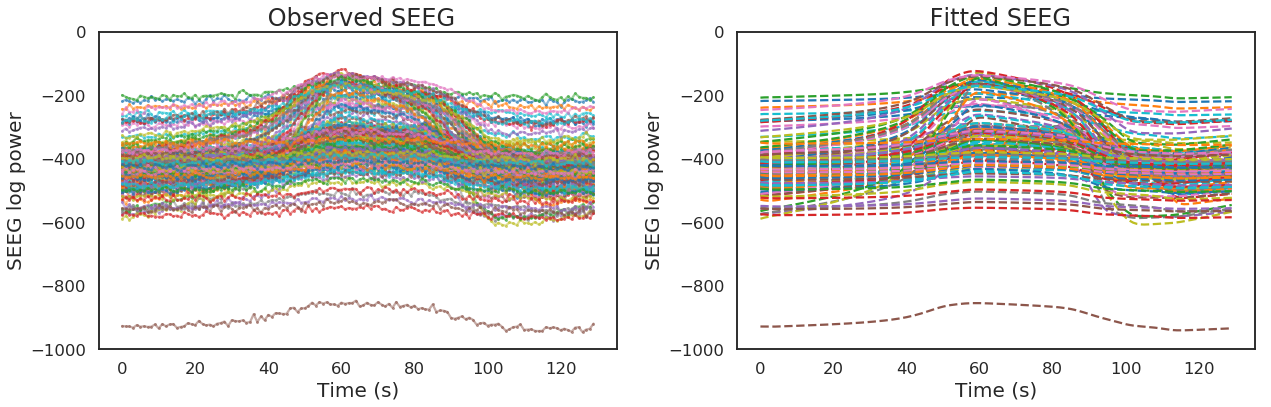

In [70]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.subplot(122)
plt.plot(ts, np.mean(Seeg_est, axis=0).T,  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

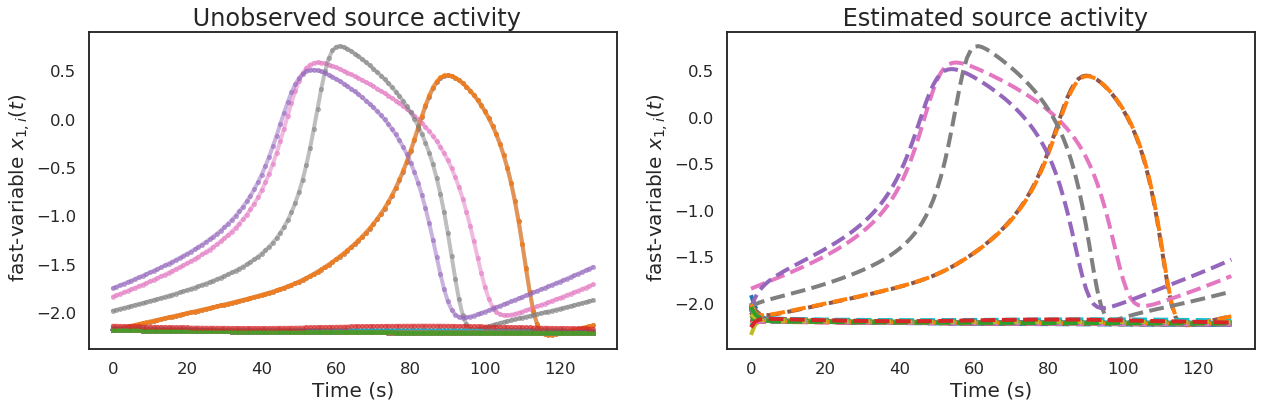

In [71]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est, axis=0),  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

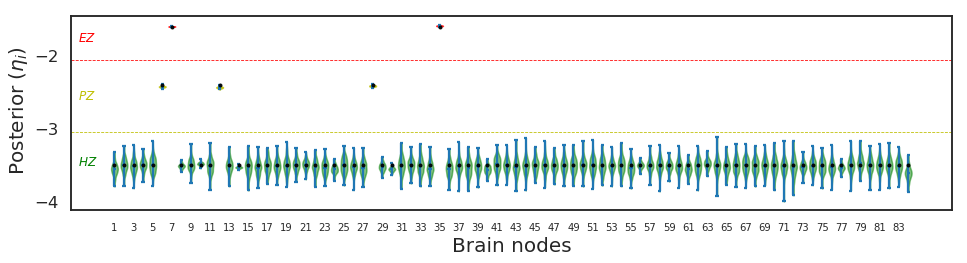

In [72]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), eta_est)
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

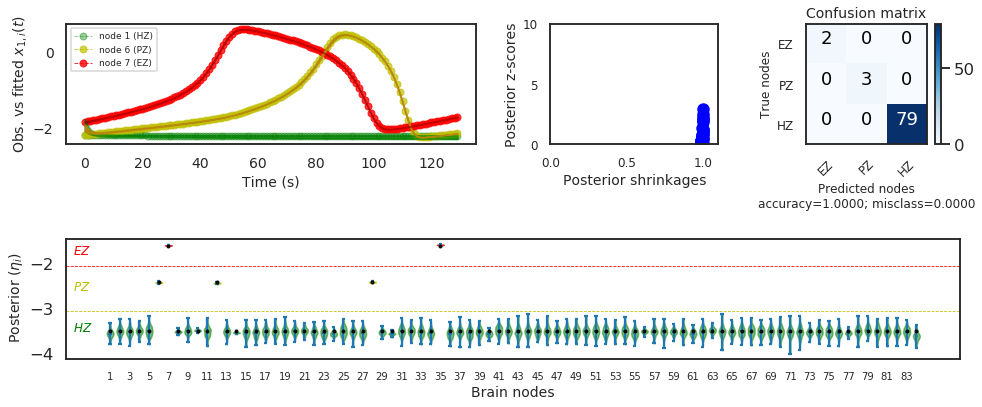

In [73]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(ts, xs, x_est, showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, eta_true_mu, eta_est_mean, eta_est_std, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), eta_est)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitSource"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitSource"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

In [74]:
Seeg_pwr_pred = np.sum((np.mean(Seeg_est, axis=0)*np.mean(Seeg_est, axis=0)), axis=1)
Seeg_pwr_n_pred = (Seeg_pwr_pred/ Seeg_pwr_pred.max())

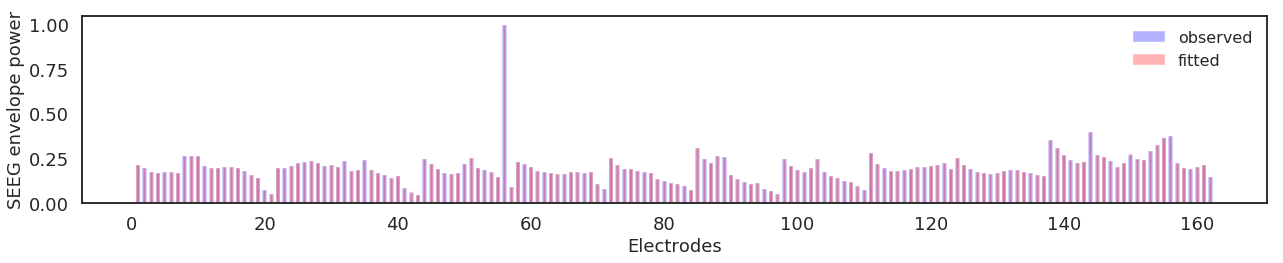

In [75]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='b', width=.7, alpha=0.3,label='observed');
plt.bar(np.arange(1,Seeg_pwr_n_pred.shape[0]+1), Seeg_pwr_n_pred ,color='r', width=.5, alpha=0.3,  label='fitted' );
plt.xlabel('Electrodes', fontsize=18)
plt.ylabel('SEEG envelope power', fontsize=18)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.legend(fontsize=16, frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitedSeeglogpower"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FitedSeeglogpower"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)

plt.show()

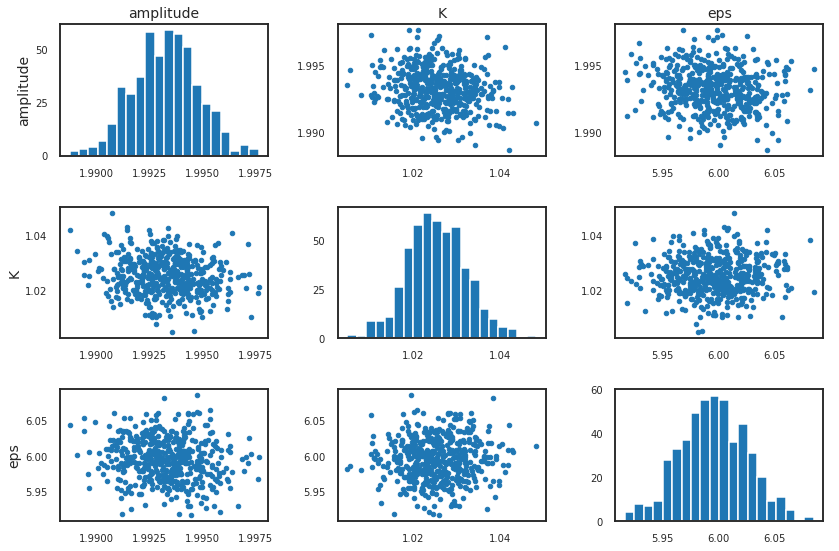

In [76]:
from lib.report_plots import pair_plots_params
extras = ' amplitude K eps'.split()              
plt.figure(figsize=(12, 8)) 
pair_plots_params(fit, extras)  
plt.tight_layout()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Pairplot"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Pairplot"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

In [77]:
from lib.report_plots import func_2DepileptorEqs,  plot_phasespace

I=I1+1;
InitialGuess=np.array([[-1.0, 3.0]])
rGuess = np.repeat(InitialGuess, int(nn), axis=0)

true_roots_K0 = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true_mu, 0.0, I, SC))
true_roots = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true_mu, Ks, I, SC))

estimated_roots_K0 = fsolve(func_2DepileptorEqs,rGuess, args=(eta_est_mean, 0.0, I, SC))
estimated_roots = fsolve(func_2DepileptorEqs,rGuess, args=(eta_est_mean, K_est.mean(), I, SC))

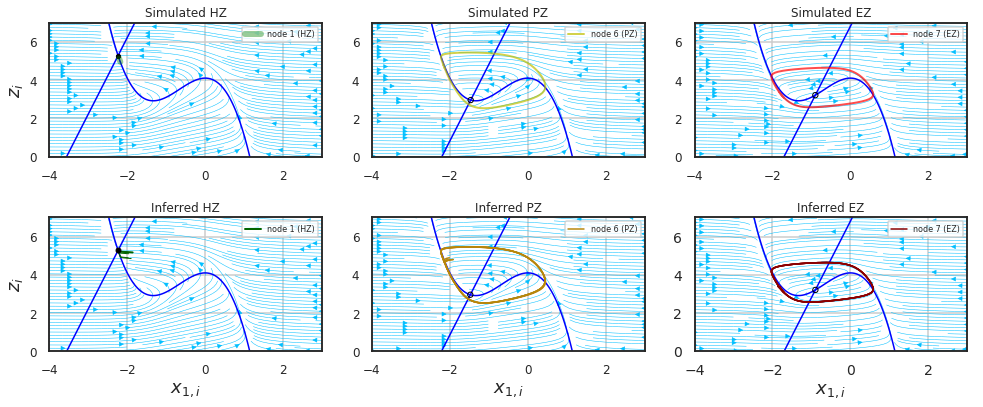

In [78]:
plt.figure(figsize=(14, 6)) 
plot_phasespace(fit, data_input, nodes, showpicks, SC,  eta_true_mu, Ks,  true_roots, true_roots_K0, estimated_roots, estimated_roots_K0,'HMC');
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Phaseplane"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Phaseplane"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show();

## Posterior convergence and diagnostics

In [79]:
divergent__=fit['divergent__'][-nSample:][:,newaxis]
stepsize__=fit['stepsize__'][-nSample:][:,newaxis]

lp__=fit['lp__'][-nSample:][:,newaxis]
accept_stat__=fit['accept_stat__'][-nSample:][:,newaxis]
energy__=fit['energy__'][-nSample:][:,newaxis]

treedepth__=fit['treedepth__'][-nSample:][:,newaxis]
n_leapfrog__=fit['n_leapfrog__'][-nSample:][:,newaxis]


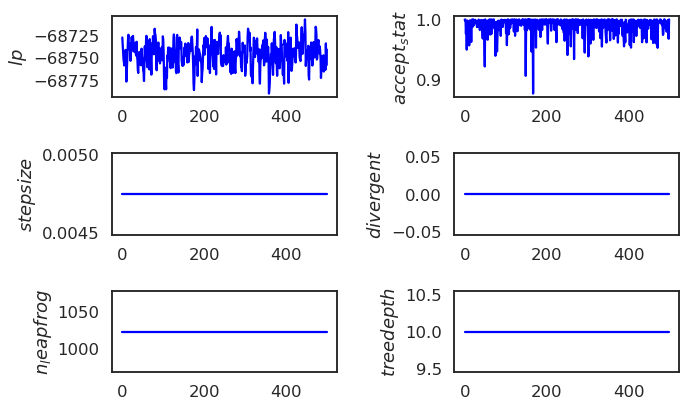

In [80]:
figure(figsize=(10, 6))

plt.subplot(321)
plt.plot(lp__, 'b')
plt.ylabel("$lp$")
plt.subplot(322)
plt.plot(accept_stat__, 'b')
plt.ylabel("$accept_stat$")

plt.subplot(323)
plt.plot(stepsize__, 'b')
plt.ylabel("$stepsize$")
plt.subplot(324)
plt.plot(divergent__, 'b')
plt.ylabel("$divergent$")

plt.subplot(325)
plt.plot(n_leapfrog__, 'b')
plt.ylabel("$n_leapfrog$")
plt.subplot(326)
plt.plot(treedepth__, 'b')
plt.ylabel("$treedepth$")

tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Nuts_diagnostics_"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Nuts_diagnostics_"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

In [81]:
from  lib.report_diagnostics_stan import  run_summary, Nuts_plot, check_rhat, check_div, check_treedepth, check_energy, check_n_eff


In [82]:
dict_samples_diagnostics=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=num_samples,  variables_of_interest=['lp__', 'energy__', 'accept_stat__', 'divergent__', 'treedepth__', 'n_leapfrog__'  ])


In [83]:
lp__, accept_stat__, treedepth__, divergent__, energy__,  = dict_samples_diagnostics['lp__'], dict_samples_diagnostics['accept_stat__'],  dict_samples_diagnostics['treedepth__'], dict_samples_diagnostics['divergent__'], dict_samples_diagnostics['energy__']


In [84]:
check_divergence__=check_div(divergent__)
check_treedepth__=check_treedepth(treedepth__, int(max_depth))
check_energy__=check_energy(energy__)

In [85]:
check_divergence__, check_treedepth__, check_energy__

(0.0, 100.0, 1.0041735080735665)

In [86]:
fit_summary=run_summary(cwd+"/", dir_data_output+"/"+str(fit_filename_csv))

fit_filefoder: data_output_hmc_BVEP2_seeg_noncentered_reparam_euler
fit_filename: output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
mycsvfile: /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
running stan summary!
finished stan summary!


In [87]:
cd ..

/data/BVEP_SEEG_benchmark


In [88]:
fit_summary

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
0,lp__,-68745.700000,1.055410e+00,1.415730e+01,-68770.100000,-68744.700000,-68724.500000,179.936000,0.048856,0.998127
1,accept_stat__,0.989786,6.459990e-04,1.442600e-02,0.960614,0.995520,0.999956,498.689000,0.135402,0.999652
2,stepsize__,0.004745,0.000000e+00,0.000000e+00,0.004745,0.004745,0.004745,0.501505,0.000136,NaN
3,treedepth__,10.000000,3.180830e-16,7.112540e-15,10.000000,10.000000,10.000000,500.000000,0.135758,0.997998
4,n_leapfrog__,1023.000000,5.089320e-14,1.138010e-12,1023.000000,1023.000000,1023.000000,500.000000,0.135758,0.997998
...,...,...,...,...,...,...,...,...,...,...
107049,log_lik_sum[129],-531.264000,4.812530e-02,1.076110e+00,-532.996000,-531.229000,-529.441000,500.000000,0.135758,0.998329
107050,log_lik_sum[130],-524.358000,4.907190e-02,1.097280e+00,-526.186000,-524.360000,-522.591000,500.000000,0.135758,0.999183
107051,gx,0.262514,1.224660e-03,2.738410e-02,0.216675,0.262603,0.308426,500.000000,0.135758,0.998783
107052,dx,-0.005225,1.946420e-05,4.352330e-04,-0.005933,-0.005215,-0.004507,500.000000,0.135758,0.998046


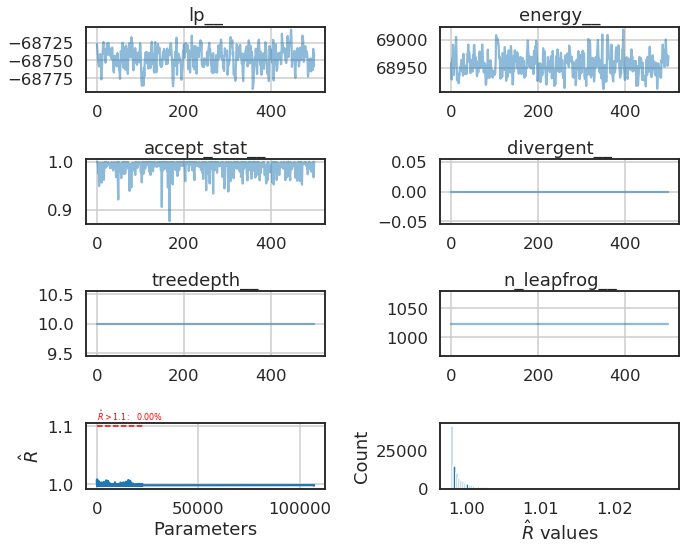

In [89]:
plt.figure(figsize=(10,8))
Nuts_plot(dict_samples_diagnostics, fit_summary)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Nuts_convergence_"+str(model)+"_chain_"+str(chain)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Nuts_convergence_"+str(model)+"_chain_"+str(chain)+".eps"), dpi=800)
plt.show()

## All chains

In [90]:
nchains=4

In [91]:
lp_bvep2_euler=np.zeros((nchains, nSample))
divergent_bvep2_euler=np.zeros((nchains, nSample))
stepsize_bvep2_euler=np.zeros((nchains, nSample))
Seeg_est_bvep2_euler=np.zeros((nchains, nSample, nt, ns))
x_est_bvep2_euler=np.zeros((nchains, nSample, nn, nt))
z_est_bvep2_euler=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep2_euler=np.zeros((nchains, nSample, nn))

In [92]:
for i in np.arange(0,nchains):
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=num_samples,  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep2_euler[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep2_euler[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep2_euler[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep2_euler[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep2_euler[i,]=dict_samples['x'][-nSample:]
        z_est_bvep2_euler[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep2_euler[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.csv
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.csv
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.csv


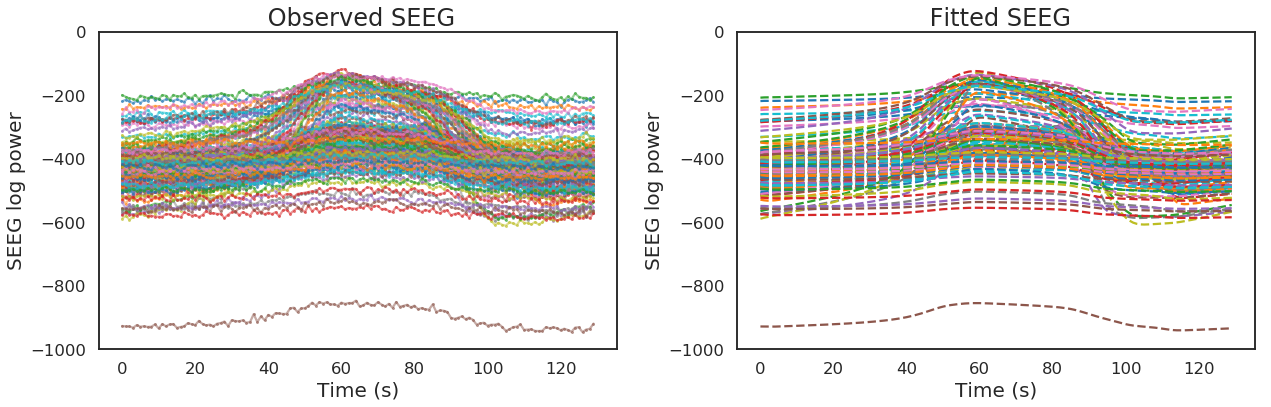

In [93]:
plt.figure(figsize=(18, 6)) 
subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep2_euler, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

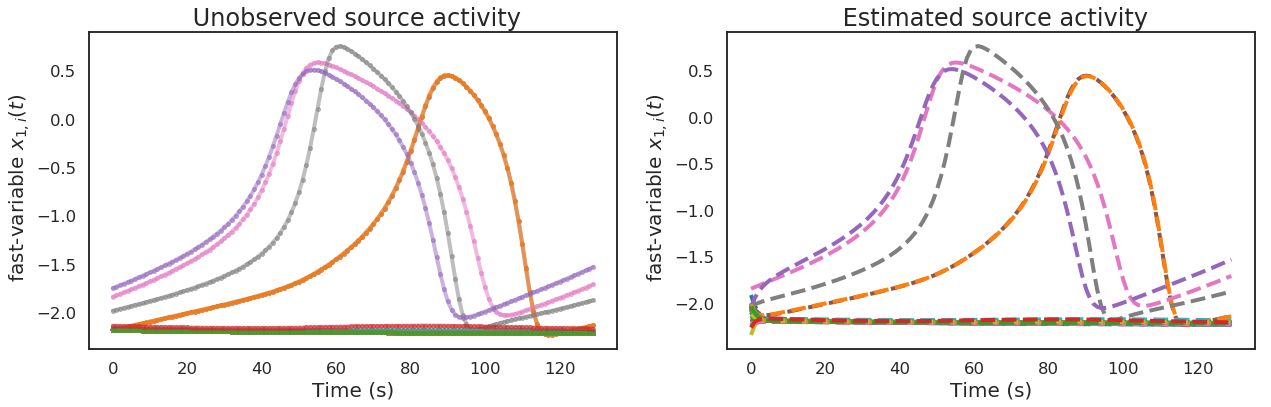

In [94]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep2_euler, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

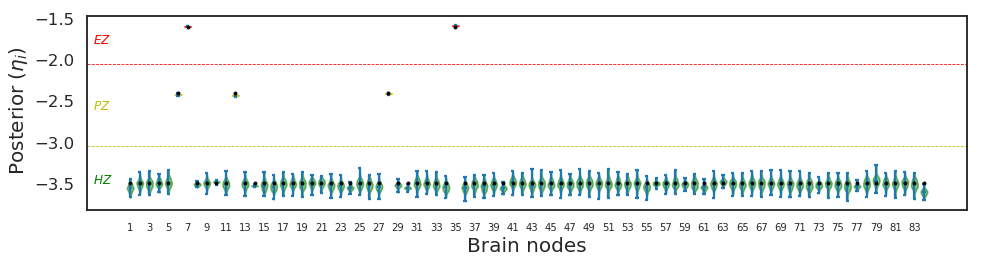

In [95]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep2_euler, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [96]:
np.mean(lp_bvep2_euler, axis=1)

array([-68745.7334, -68746.0756, -68746.3984, -68745.3   ])

In [97]:
np.mean(stepsize_bvep2_euler, axis=1)

array([0.00474493, 0.00300232, 0.00405813, 0.00376017])

In [98]:
check_div(divergent_bvep2_euler.reshape(-1))

0.0